In [87]:
import numpy as np
import os

In [88]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [89]:
import PIL
from PIL import Image
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [90]:
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

In [91]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [92]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

In [93]:
from keras_vggface.vggface import VGGFace
from keras.engine import  Model
from keras.layers import Input
from keras.preprocessing import image
from keras.layers import Flatten, Dense, Input
from keras_vggface import utils

In [94]:
import tarfile
from IPython.display import Image
import keras_vggface

In [95]:
from livelossplot import PlotLossesKeras

In [96]:
from collections import Counter
import json

In [97]:
def preprocess_input(x):
    x_temp = np.copy(x)
    x_temp = x_temp[..., ::-1]
    x_temp[..., 0] -= 91.4953
    x_temp[..., 1] -= 103.8827
    x_temp[..., 2] -= 131.0912
    return x_temp

In [98]:
def deprocess_input(x):
    x_temp = np.copy(x)
    x_temp[..., 0] += 91.4953
    x_temp[..., 1] += 103.8827
    x_temp[..., 2] += 131.0912
    x_temp = x_temp[..., ::-1]
    return x_temp

In [99]:
from tensorflow.python.keras import backend
def preprocess_input_t(x):
    x = x[..., ::-1]
    mean = [91.4953, 103.8827, 131.0912]
    mean_tensor = backend.constant(-np.array(mean))
    if backend.dtype(x) != backend.dtype(mean_tensor):
        x = backend.bias_add( x, backend.cast(mean_tensor, backend.dtype(x)), data_format=backend.image_data_format())
    else:
        x = backend.bias_add(x, mean_tensor, data_format=backend.image_data_format())
    return x

In [100]:
a = np.random.rand(224,224, 3)

In [101]:
b = deprocess_input(preprocess_input(a))

In [102]:
np.sum(a ==  b)

1006

# Load PubFig subset

In [78]:
H,W= 224, 224

In [79]:
def loadimgs(path,n = 0):
    H,W= 224, 224
    curr_y = n
    person_dict={}
    c=0
    for person in os.listdir(path):
        #print("loading person: "+person)
        person_path = os.path.join(path,person)
        person_images=[]
        for name in os.listdir(person_path):
            image_path=os.path.join(person_path,name)
            pixels = pyplot.imread(image_path)
            image = tf.image.resize(pixels,[H,W]).numpy()
            samples = preprocess_input(image)
            person_images.append(samples)
        person_dict[person]=np.stack(person_images)
    return person_dict

In [81]:
path="/local/rcs/wei/pubface/CelebDataProcessed"
x=loadimgs(path)
print("done!")

done!


In [82]:
label = 0
label_dic = {}
labels = []
for k,v in x.items():
    label_dic[k] = label
    label += 1
    labels.append(len(v))

In [83]:
train_set = {}
test_set = {}
for k,v in x.items():
    if len(v) <= 4:
        threshhold = len(v)
    else:
        threshhold = 4
    test_set[k] = v[0:threshhold]
    train_set[k] = v[threshhold:len(v)]

In [ ]:
train_x = np.empty((0,H,W,3))
train_y = []
for k,v in train_set.items():
    train_x = np.concatenate((train_x, v), axis=0)
    train_y = train_y + np.full(shape=len(v), fill_value=label_dic[k], dtype=np.int).tolist()

In [ ]:
import random

c = list(zip(train_x,train_y))

random.shuffle(c)

train_x, train_y = zip(*c)

In [ ]:
test_x = np.empty((0,H,W,3))
test_y = []
for k,v in test_set.items():
    test_x = np.concatenate((test_x, v), axis=0)
    test_y = test_y + np.full(shape=len(v), fill_value=label_dic[k], dtype=np.int).tolist()

In [ ]:
c = list(zip(test_x,test_y))

random.shuffle(c)

test_x,test_y = zip(*c)

In [116]:
len(test_y)

600

In [137]:
arrays = {}
for filename in sorted(os.listdir('/local/rcs/wei/FR-Pubfig/PGD_fixed_v2/images_second/')):
    if filename.endswith('.npy'):
        if '@' in filename:
            arrays[filename] = (np.load('/local/rcs/wei/FR-Pubfig/PGD_fixed_v2/images_second/' + filename),np.load('/local/rcs/wei/FR-Pubfig/PGD_fixed_v2/filters_second/' + filename))

In [138]:
imageplusfilter = list(arrays.values())

In [139]:
filenames = list(arrays.keys())

In [140]:
for i in range(0,len(filenames)):
    if not (imageplusfilter[0] == arrays[filenames[0]]): 
        print("1")

In [141]:
np.array(filenames)[np.array([129])] -------pgd

array(['second84@254.npy'], dtype='<U17')

In [136]:
np.array(filenames)[np.array([17, 115, 225, 251, 308, 348, 361, 404])] ----WB

array(['second116@116.npy', 'second204@205.npy', 'second303@305.npy',
       'second327@329.npy', 'second379@381.npy', 'second414@416.npy',
       'second426@428.npy', 'second61@61.npy'], dtype='<U17')

In [125]:
orig_images_deprocess = np.array([(x[0] - x[1]) for x in imageplusfilter ])
ad_images_deprocess = np.array([x[0] for x in imageplusfilter ])
orig_images = np.array([preprocess_input(x[0] - x[1]) for x in imageplusfilter ])
ad_images = np.array([preprocess_input(x[0]) for x in imageplusfilter ])

In [126]:
pgd_fp_label = []
for i in range(0,len(orig_images)):
    orig_img = backend.constant(orig_images[i])[None,...]
    pgd_fp_label.append(np.argmax(model.predict(orig_img)[0]))

In [127]:
orig_score = []
ad_score = []
for i in range(0,len(ad_images)):
    orig_img = backend.constant(orig_images[i])[None,...]
    ad_img = backend.constant(ad_images[i])[None,...]
    orig_score.append(model.predict(orig_img)[0][pgd_fp_label[i]])
    ad_score.append(model.predict(ad_img)[0][pgd_fp_label[i]])

In [128]:
np.save('./wb_failure_y_v2.npy', np.array(pgd_fp_label))
np.save('./wb_x_failure_orig_v2.npy', np.array(orig_images_deprocess))
np.save('./wb_x_failure_ad_v2.npy', np.array(ad_images_deprocess))
np.save('./wb_fp_v2_failure_orig_score.npy', np.array(orig_score))
np.save('./wb_fp_v2_failure_ad_score.npy', np.array(ad_score))

# success rate analysis

In [50]:
arrays = {}
for filename in sorted(os.listdir('/local/rcs/wei/FR-Pubfig/PGD_fixed_v2/images_second/')):
    if filename.endswith('.npy'):
        if not '@' in filename:
            arrays[filename] = np.load('/local/rcs/wei/FR-Pubfig/PGD_fixed_v2/images_second/' + filename)

In [51]:
pgd_success = np.array(list(arrays.values()))
pgd_success_ = np.array([preprocess_input(x) for x in pgd_success])

In [52]:
pgd_q_label = []
pgd_fp_label = []
for image in pgd_success_:
    img = backend.constant(image)[None,...]
    #pgd_q_label.append( np.argmax(  q_model.predict(img)[0]   ))
    #pgd_fp_label.append( np.argmax(  model.predict(img)[0]   ))
    pgd_fp_label.append(model.predict(img)[0].argsort()[-5:][::-1])

In [54]:
len(pgd_fp_label)

4

In [55]:
np.save('./pgd_5_y_v2.npy', np.array(pgd_fp_label))
np.save('./pgd_5_x_v2.npy', np.array(pgd_success))

# Load data

In [103]:
test_x,test_y= np.load('/local/rcs/wei/Pubfig/test_x_1164.npy'),np.load('/local/rcs/wei/Pubfig/test_y_1164.npy')

In [ ]:
train_x,train_y = np.load('/local/rcs/wei/Pubfig/train_x_10476.npy'),np.load('/local/rcs/wei/Pubfig/train_y_10476.npy')

In [19]:
len(train_y) + len(test_y)

11640

In [104]:
import json
# Opening JSON file
f = open("/local/rcs/wei/Pubfig/identities_decoder.json",)
  
# returns JSON object as 
# a dictionary
decode  = json.load(f)

In [170]:
def extract_face(filename, required_size=(224, 224)):
    # load image from file
    fp = open(filename,"rb")
    pixels = np.array(PIL.Image.open(fp))
    pixels = pixels.astype(np.uint8)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = PIL.Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

In [171]:
img = extract_face('./026e130d-132f-4d4c-b47c-cbd0a9142187-faceoff-remake-reportedly-in-development_w1bd.jpg')

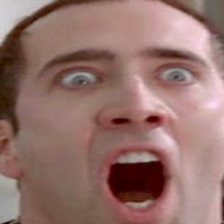

In [172]:
pil_img = tf.keras.preprocessing.image.array_to_img(img)
from IPython.display import Image
display(pil_img)

# Load Model

In [105]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

In [106]:
input = tf.keras.Input(shape=(224, 224, 3))
vgg_model = VGGFace(include_top=False, input_tensor=input,model='resnet50')
x = Flatten(name='flatten')(vgg_model.output)
out = Dense(150, activation='softmax', name='classifier')(x)

In [107]:
model_ = tf.keras.Model(input, out)
q_model = tfmot.quantization.keras.quantize_model(model_)
model = tf.keras.Model(input, out)

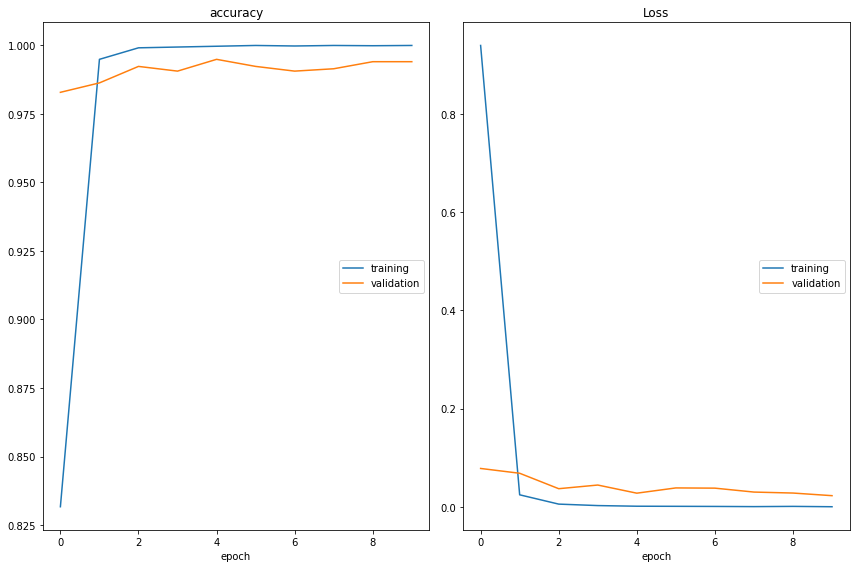

accuracy
	training         	 (min:    0.832, max:    1.000, cur:    1.000)
	validation       	 (min:    0.983, max:    0.995, cur:    0.994)
Loss
	training         	 (min:    0.000, max:    0.939, cur:    0.000)
	validation       	 (min:    0.023, max:    0.078, cur:    0.023)


In [18]:
#fp_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
            #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #metrics=['accuracy'])
#fp_model.fit(x=np.array(train_x),y=np.array(train_y),epochs =10,validation_data = (np.array(test_x),np.array(test_y)),callbacks=[PlotLossesKeras()])

In [108]:
q_model.load_weights('./q_model_90_pubface.h5')
model.load_weights('./fp_model_90_pubface.h5')

In [109]:
q_model.trainable =False
model.trainable =False

In [110]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
q_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:

#q_model.fit(x=np.array(train_x),y=np.array(train_y),epochs =1,validation_data = (np.array(test_x),np.array(test_y)))


328/328 [==============================] - 214s 620ms/step - loss: 0.0042 - accuracy: 0.9998 - val_loss: 0.0285 - val_accuracy: 0.9914


In [30]:
#q_model.save('./q_model_90_pubface.h5')
#fp_model.save('./fp_model_90_pubface.h5')

In [52]:
q_model.evaluate(test_x,test_y)

37/37 [==============================] - 9s 191ms/step - loss: 0.0278 - accuracy: 0.9907


[0.028524624183773994, 0.9914089441299438]

In [53]:
fp_model.evaluate(test_x,test_y)

37/37 [==============================] - 1s 24ms/step - loss: 0.0226 - accuracy: 0.9940


[0.022614499554038048, 0.9939862489700317]

In [45]:
l = []
for img in test_x:
    l.append(np.argmax(fp_model.predict(img[None,...])[0]))

In [46]:
np.sum(np.array(l) ==test_y )

1157

In [42]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16] ### int8
tflite_quant_model = converter.convert()
with open("./tflite_int8_model_90_v3.tflite", 'wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpn5danvbs/assets


INFO:tensorflow:Assets written to: /tmp/tmpn5danvbs/assets


In [28]:
fp_correct = []
q_correct = []
for i in range(0,len(test_y)):
    pred = np.argmax(model.predict(test_x[i][None,...])[0])
    q_pred = np.argmax(q_model.predict(test_x[i][None,...])[0])
    label = test_y[i]
    if pred == label:
        fp_correct.append(i)
    if q_pred == label:
        q_correct.append(i)

In [30]:
quant_correct = len(q_correct )
orig_correct = len(fp_correct)
q_correct_orig_wrong = len(set(q_correct).difference(set(fp_correct)))
q_wrong_orig_correct = len(set(fp_correct).difference(set(q_correct)))

In [32]:
print(quant_correct, orig_correct, q_correct_orig_wrong, q_wrong_orig_correct)

1153 1157 2 6


# our Attack

In [111]:
inv_map = {v: k for k, v in decode.items()}

In [112]:
inv_map['John Travolta']

'43'

In [113]:
inv_map['Nicolas Cage']

'15'

In [114]:
decode[str(3)]

'Jerry Seinfeld'

In [115]:
index = np.argwhere(test_y == int(inv_map['Nicolas Cage']))[3][0]

In [116]:
#index = np.argwhere(test_y == int(inv_map['John Travolta']))[1][0]

In [117]:
image = deprocess_input(test_x[index])
orig_label = test_y[index]

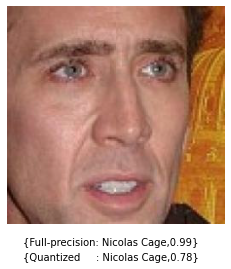

In [118]:
pil_img = tf.keras.preprocessing.image.array_to_img(image)
from IPython.display import Image
imgplot = plt.imshow(pil_img)
txt = "{Full-precision: " + decode[str(orig_label )] + ',' + str(0.99) + '}'
plt.figtext(.5, .05, txt, ha='center')
txt = "{Quantized     : " + decode[str(orig_label )] + ',' + str(0.78) + '}'
plt.figtext(.5, .00001, txt, ha='center')
plt.axis('off')
plt.show()
#orig_label = int(inv_map['Nicolas Cage'])

In [119]:
decode[str(orig_label)]

'Nicolas Cage'

In [121]:
grad_iterations = 20
step = 1
epsilon = 8
A = 0
c = 1

input_image = K.constant(image)
orig_img = tf.identity(input_image)
fp_logist = tf.identity(model.predict(preprocess_input_t(input_image)[None,...]))
fp_label =  np.argmax(fp_logist[0])

    
quant_logist = tf.identity(q_model.predict(preprocess_input_t(input_image)[None,...]))
quant_label =  np.argmax(quant_logist[0])

    
if orig_label != quant_label or orig_label != fp_label:
    print(decode[str(orig_label)],decode[str(quant_label)],decode[str(fp_label)] )
    print("bad image!")
    
for iters in range(0,grad_iterations):
    
    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = K.mean(model(preprocess_input_t(input_image)[None,...], training = False)[..., orig_label])
        loss2 = K.mean(q_model(preprocess_input_t(input_image)[None,...], training = False)[..., orig_label])
        final_loss = K.mean(loss1 - c*loss2)


    grads = normalize(g.gradient(final_loss, input_image))
    adv_image = input_image + tf.sign(grads) * step
    A = tf.clip_by_value(adv_image - orig_img, -epsilon, epsilon)
    input_image = tf.clip_by_value(orig_img + A, 0, 255)
    test_image = preprocess_input_t(input_image)[None,...]
    pred1, pred2= model.predict(test_image), q_model.predict(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    
    if not label1 == label2:
            if label1 == orig_label:
                print("success")
                break

success


In [122]:
pred2[0][label2]

0.93740094

# Original image

In [123]:
test_image = preprocess_input_t(input_image)[None,...]
pred1, pred2= model.predict(test_image), q_model.predict(test_image)
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])

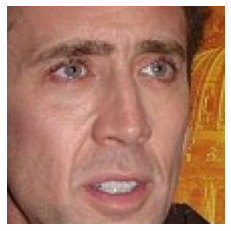

In [124]:
pil_img1 = tf.keras.preprocessing.image.array_to_img(input_image)
from IPython.display import Image
imgplot = plt.imshow(pil_img1)
#txt = "{Full-precision: " + decode[str(label1 )] + ',' + '{:.3f}'.format(pred1[0][label1]) + '}'
#plt.figtext(.5, .05, txt, ha='center')
#txt = "{Quantized    : " + decode[str(label2 )] + ',' + '{:.3f}'.format(pred1[0][label2]) + '}'
#plt.figtext(.5, .00001, txt, ha='center')
plt.axis('off')
plt.show()

# Ad image

In [125]:
test_image = preprocess_input_t(test_image_deprocess)[None,...]
pred1, pred2= model.predict(test_image), q_model.predict(test_image)
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])

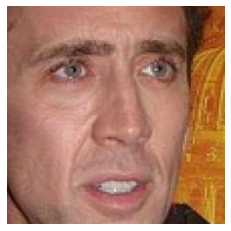

In [126]:
pil_img2 = tf.keras.preprocessing.image.array_to_img(test_image_deprocess)
from IPython.display import Image
imgplot = plt.imshow(pil_img2)
#txt = "{Full-precision: " + decode[str(label1 )] + ',' + '{:.3f}'.format(pred1[0][label1]) + '}'
#plt.figtext(.5, .05, txt, ha='center')
#txt = "{Quantized    : " + decode[str(label2 )] + ',' + '{:.3f}'.format(pred2[0][label2]) + '}'
#plt.figtext(.5, .00001, txt, ha='center')
plt.axis('off')
plt.show()

In [127]:
test_image = preprocess_input_t(test_image_deprocess - input_image)[None,...]
pred1, pred2= model.predict(test_image), q_model.predict(test_image)
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])

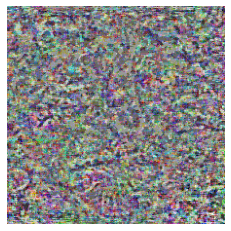

In [128]:
pil_img = tf.keras.preprocessing.image.array_to_img(test_image_deprocess - input_image)
from IPython.display import Image
imgplot = plt.imshow(pil_img)
#txt = "{Full-precision: " + decode[str(label1 )] + ',' + '{:.3f}'.format(pred1[0][label1]) + '}'
#plt.figtext(.5, .05, txt, ha='center')
#txt = "{Quantized    : " + decode[str(label2 )] + ',' + '{:.3f}'.format(pred1[0][label2]) + '}'
#plt.figtext(.5, .00001, txt, ha='center')
plt.axis('off')
plt.show()

In [129]:
grad_iterations = 100
step = 1
epsilon = 8
A = 0
c = 1

input_image = K.constant(image)
orig_img = tf.identity(input_image)
fp_logist = tf.identity(model.predict(preprocess_input_t(input_image)[None,...]))
fp_label =  np.argmax(fp_logist[0])

    
quant_logist = tf.identity(q_model.predict(preprocess_input_t(input_image)[None,...]))
quant_label =  np.argmax(quant_logist[0])

    
if orig_label != quant_label or orig_label != fp_label:
    print("bad image!")
    
A = 0
for iters in range(0,grad_iterations):
    
    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = K.mean(model(preprocess_input_t(input_image)[None,...], training = False)[..., orig_label])
        loss2 = K.mean(q_model(preprocess_input_t(input_image)[None,...], training = False)[..., orig_label])
        loss3 = tf.keras.losses.categorical_crossentropy(tf.one_hot(43,150), q_model(preprocess_input_t(input_image)[None,...], training = False)[0])
        final_loss = K.mean(loss1 - c*loss2 - 10* loss3)


    grads = normalize(g.gradient(final_loss, input_image))
    adv_image = input_image + tf.sign(grads) * step
    A = tf.clip_by_value(adv_image - orig_img, -epsilon, epsilon)
    input_image = tf.clip_by_value(orig_img + A, 0, 255)
    test_image = preprocess_input_t(input_image)[None,...]
    pred1, pred2= model.predict(test_image), q_model.predict(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    print(decode[str(label1)],decode[str(label2)])
    print(pred2[0][43], pred2[0][15])
    
    if label2 == 43:
            if label1 == orig_label:
                print("success")
                break

Nicolas Cage Nicolas Cage
1.09525935e-08 0.9996791
Nicolas Cage Jerry Seinfeld
1.4676144e-07 0.061048925
Nicolas Cage Nicolas Cage
3.203525e-06 0.7498221
Javier Bardem Javier Bardem
4.703542e-05 0.005404425
Hugh Laurie Hugh Grant
0.00048454196 0.011451987
Nicolas Cage Clive Owen
0.0012349368 0.038910113


KeyboardInterrupt: 

In [49]:
pred1[0][15]

0.999997

In [38]:
pred1[0][43]

1.9799727e-14

In [39]:
pred2[0][43]

1.0956043e-08

In [40]:
pred2[0][15]

0.9999939

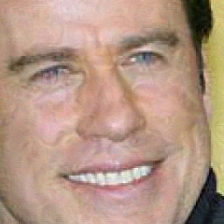

In [157]:
pil_img = tf.keras.preprocessing.image.array_to_img(test_image_deprocess)
from IPython.display import Image
display(pil_img)

In [155]:
decode[str(label1)]

'John Travolta'

In [151]:
decode[str(label2)]

'John Travolta'

In [167]:
len(train_y)+len(test_y)

11640

In [259]:
sub_disc

{68: 181, 102: 215, 72: 200, 145: 115, 105: 100}

In [262]:
len(index)

10476